In [1]:
import cv2
import yaml
import pandas as pd
import orbslam3
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
from orbslam_k2 import ORBSLAM3
from sensor_utils import sync_video, convert_logs_to_csv, read_synced_logs

In [3]:
from main import timedelta_from_string

In [4]:
PROJECT_DIR = Path("..") / ".."
VOCABLUARY_PATH = PROJECT_DIR / "Vocabluary" / "ORBvoc.txt"

VIDEO_FOLDER = Path("cam1_lens100_alt600")
CONFIG_PATH = VIDEO_FOLDER / "config.yaml"
ORB_CONFIG_PATH = VIDEO_FOLDER / "orb_config.yaml"

DATA_DIR = PROJECT_DIR / "data" / "k2" / VIDEO_FOLDER

In [5]:
with open(str(CONFIG_PATH), "r") as f:
    config = yaml.load(f, Loader=yaml.BaseLoader)

In [6]:
offset = pd.Timedelta(minutes=5, seconds=0) # timedelta_from_string(config["offset"])
log_start = timedelta_from_string(config["log_start"]) + offset
video_start = timedelta_from_string(config["video_start"]) + offset

In [7]:
vid = cv2.VideoCapture(str(DATA_DIR / config["video_name"]))
vid, fps = sync_video(vid, video_start)

In [8]:
logs = read_synced_logs(DATA_DIR / config["csv_log_name"], fps, log_start)

In [9]:
slam = ORBSLAM3(str(VOCABLUARY_PATH), str(ORB_CONFIG_PATH), orbslam3.Sensor.MONOCULAR, True)


ORB-SLAM3 Copyright (C) 2017-2020 Carlos Campos, Richard Elvira, Juan J. Gómez, José M.M. Montiel and Juan D. Tardós, University of Zaragoza.
ORB-SLAM2 Copyright (C) 2014-2016 Raúl Mur-Artal, José M.M. Montiel and Juan D. Tardós, University of Zaragoza.
This program comes with ABSOLUTELY NO WARRANTY;
This is free software, and you are welcome to redistribute it
under certain conditions. See LICENSE.txt.

Input sensor was set to: Monocular
Loading settings from cam1_lens100_alt600/orb_config.yaml
	-Loaded camera 1
	-Loaded image info
	-Loaded ORB settings
	-Loaded viewer settings
	-Loaded Atlas settings
	-Loaded misc parameters
----------------------------------
SLAM settings: 
	-Camera 1 parameters (Pinhole): [ 2339.38 2378.1 1312.66 524.976 ]
	-Camera 1 distortion parameters: [  -0.108419 0.650409 -0.000980865 -0.00764924 -1.69708 ]
	-Original image size: [ 1920 , 1080 ]
	-Current image size: [ 1920 , 1080 ]
	-Camera 1 parameters after resize: [  2339.38 2378.1 1312.66 524.976 ]
	-Se

Viewer.imageViewScale optional parameter does not exist...
System.LoadAtlasFromFile optional parameter does not exist...
System.SaveAtlasToFile optional parameter does not exist...
System.thFarPoints optional parameter does not exist...


In [10]:
def display_frame_with_log(frame, log):
    # Add log information to the frame
    log_text = f"Log info: x={log['x']:.2f}, y={log['y']:.2f}, z={log['z']:.2f}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_color = (255, 255, 255)  # White text
    font_thickness = 2
    x, y = 10, 30  # Position of the text on the frame
    cv2.putText(frame, log_text, (x, y), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

    # Show the frame
    cv2.imshow("Main", frame)
    cv2.waitKey(1)

In [13]:
frame.shape

(1080, 1920, 3)

In [11]:
for i in tqdm(range(5000)):
    _, frame = vid.read()
    log = logs.iloc[i]
    slam.step(frame, log)
    display_frame_with_log(frame, log)
cv2.destroyAllWindows()

  0%|          | 2/5000 [00:00<05:41, 14.65it/s]

Starting the Viewer


 12%|█▏        | 619/5000 [00:46<05:28, 13.33it/s]


KeyboardInterrupt: 

In [13]:
pred_trajectory = slam.get_trajectory_df()

In [47]:
combined_trajectory = pred_trajectory.join(logs, lsuffix="_pred")

In [64]:
combined_trajectory = combined_trajectory.interpolate()

In [108]:
def plot_trajectory(df, column_suffix, ax, title, color):
    x_column = f'x{column_suffix}'
    y_column = f'y{column_suffix}'

    # Plot the trajectory data
    ax.plot(df[x_column], df[y_column], label=title, color=color)
    ax.set_title(title)
    ax.set_xlabel('X (North)')
    ax.set_ylabel('Y (East)')
    ax.legend()

    # Add direction arrows for the trajectory
    arrow_scale = 0.2
    arrow_step = len(df)
    for i in range(0, len(df) - 1, 50):
        dx = df[x_column][i + 1] - df[x_column][i]
        dy = df[y_column][i + 1] - df[y_column][i]
        ax.arrow(
            df[x_column][i], df[y_column][i], 
            arrow_scale * dx, arrow_scale * dy, 
            shape='full', lw=0, length_includes_head=True, 
            head_width=5, color=color
        )


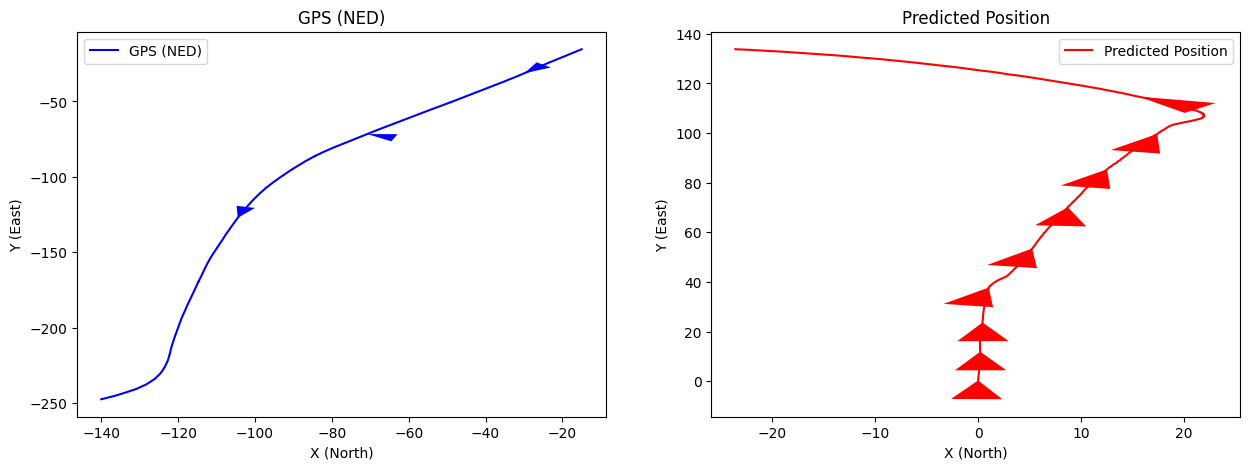

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_trajectory(combined_trajectory, "", ax1, "GPS (NED)", "blue")
plot_trajectory(combined_trajectory, "_pred", ax2, "Predicted Position", "red")

plt.show()
